In [1]:
!pip install -r ../../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = 0.85
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Data prepare

In [7]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [8]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_flip_add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [9]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(1683000, 2, 128)
[2, 128]


In [10]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
1480/1480 [==============================] - 127s 76ms/step - loss: 1.4563 - val_loss: 1.1914
Epoch 2/100
1480/1480 [==============================] - 114s 77ms/step - loss: 1.1698 - val_loss: 1.1223
Epoch 3/100
1480/1480 [==============================] - 116s 79ms/step - loss: 1.1348 - val_loss: 1.1167
Epoch 4/100
1480/1480 [==============================] - 113s 76ms/step - loss: 1.1184 - val_loss: 1.1044
Epoch 5/100
1480/1480 [==============================] - 121s 82ms/step - loss: 1.1062 - val_loss: 1.1099
Epoch 6/100
1480/1480 [==============================] - 115s 78ms/step - loss: 1.0953 - val_loss: 1.0966
Epoch 7/100
1480/1480 [==============================] - 112s 76ms/step - loss: 1.0857 - val_loss: 1.0708
Epoch 8/100
1480/1480 [==============================] - 115s 78ms/step - loss: 1.0758 - val_loss: 1.0689
Epoch 9/100
1480/1480 [==============================] - 115s 78ms/step - loss: 1.0690 - val_loss: 1.0573
Epoch 10/100
1480/1480 [======================

1480/1480 [==============================] - 104s 70ms/step - loss: 0.8481 - val_loss: 0.8265
Epoch 77/100
1480/1480 [==============================] - 104s 70ms/step - loss: 0.8466 - val_loss: 0.8157
Epoch 78/100
1480/1480 [==============================] - 103s 69ms/step - loss: 0.8459 - val_loss: 0.8192
Epoch 79/100
1480/1480 [==============================] - 102s 69ms/step - loss: 0.8452 - val_loss: 0.8258 - loss: 
Epoch 80/100
1480/1480 [==============================] - 102s 69ms/step - loss: 0.8415 - val_loss: 0.8115
Epoch 81/100
1480/1480 [==============================] - 102s 69ms/step - loss: 0.8423 - val_loss: 0.8114
Epoch 82/100
1480/1480 [==============================] - 102s 69ms/step - loss: 0.8393 - val_loss: 0.8104
Epoch 83/100
1480/1480 [==============================] - 106s 71ms/step - loss: 0.8398 - val_loss: 0.8066loss: 0
Epoch 84/100
1480/1480 [==============================] - 108s 73ms/step - loss: 0.8374 - val_loss: 0.8046
Epoch 85/100
1480/1480 [==========

# Evaluate and Plot Model Performance

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

33/33 [==============================] - 1s 27ms/step - loss: 1.2660
1.265957236289978


## Loss

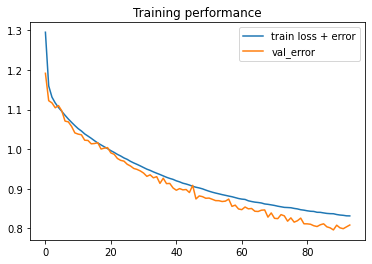

In [13]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

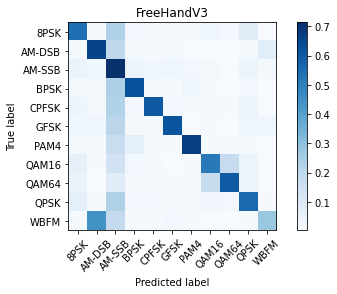

In [14]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09044908285895004
Overall Accuracy:  0.09431605246720799
Overall Accuracy:  0.10096153846153846
Overall Accuracy:  0.11123986095017381
Overall Accuracy:  0.14114114114114115
Overall Accuracy:  0.1816535908267954
Overall Accuracy:  0.31635071090047395
Overall Accuracy:  0.4591651542649728
Overall Accuracy:  0.628486646884273
Overall Accuracy:  0.745260663507109
Overall Accuracy:  0.8260333127698951
Overall Accuracy:  0.8654194327097163
Overall Accuracy:  0.8844926611359285
Overall Accuracy:  0.8858363858363858
Overall Accuracy:  0.8921977367480644
Overall Accuracy:  0.8778673279603224
Overall Accuracy:  0.867462311557789
Overall Accuracy:  0.8829268292682927
Overall Accuracy:  0.8788968824940048
Overall Accuracy:  0.8788584740827023


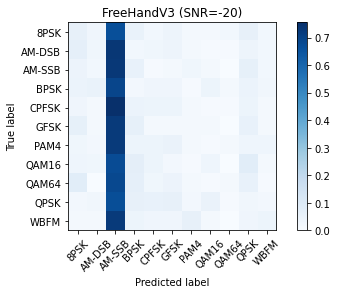

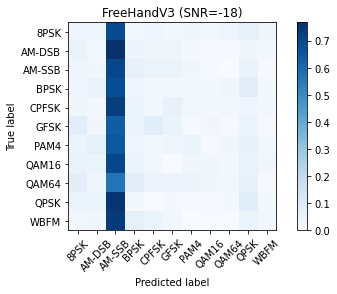

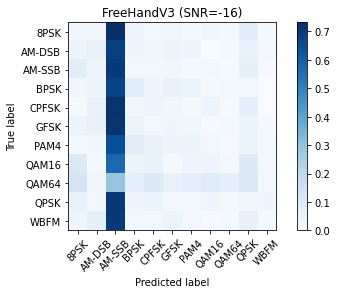

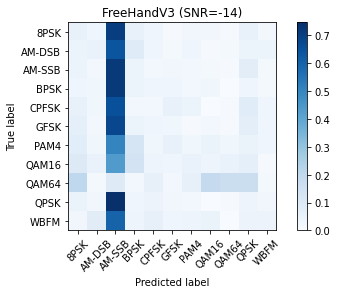

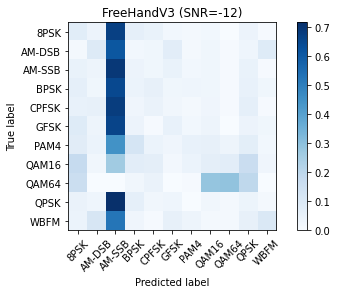

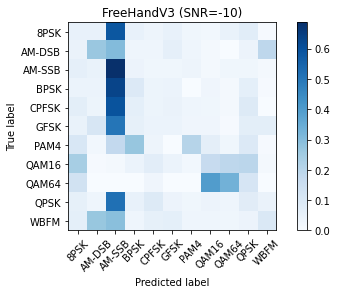

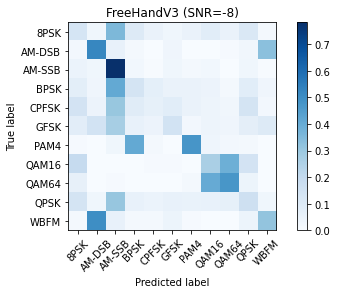

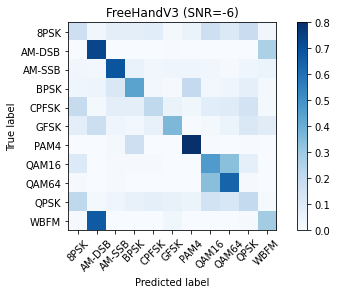

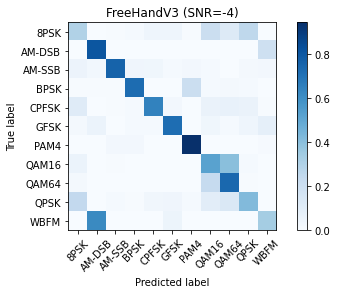

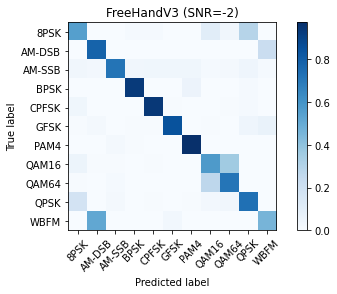

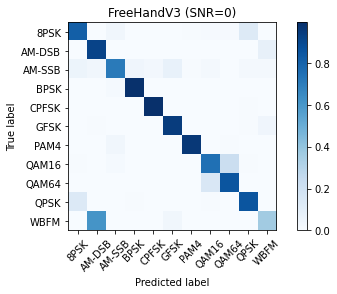

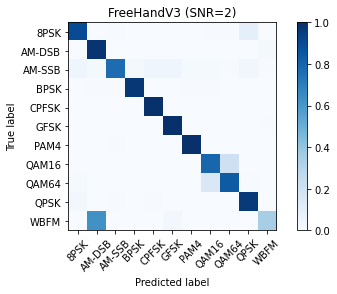

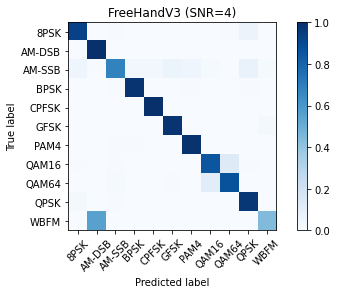

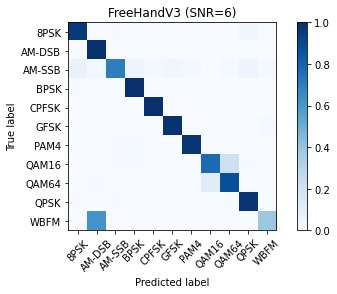

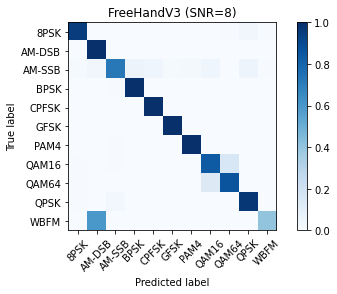

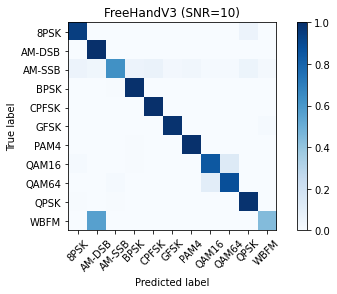

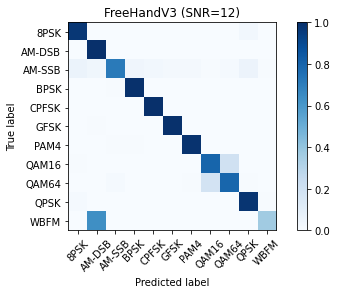

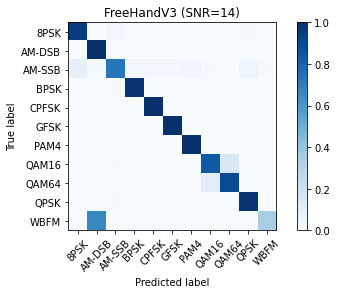

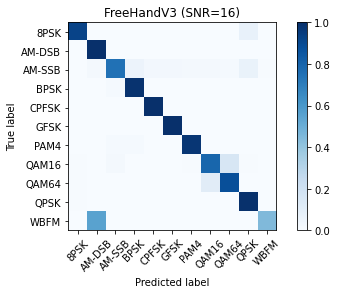

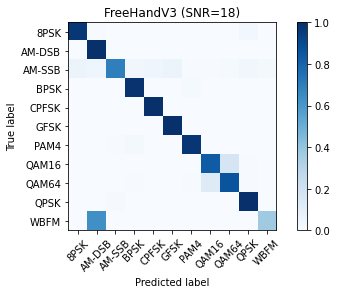

In [15]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [16]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,10,11,14,18,31,45,62,74,82,86,88,88,89,87,86,88,87,87


In [17]:
import statistics

statistics.mean(acc.values())

0.5804507898412868

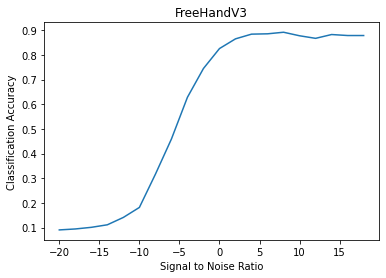

In [18]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)